# Mouse skull 3D atlas v00
In this notebook we run registration for mouse data with skull, MD816.  Here we just look at 3D datasets.


Note atlas MRI is 50,50,50 micron

We will map to CCF which is 50,50,50.



In [1]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
import emlddmm
import json
import nrrd
import os


# for debugging only
import imp
imp.reload(emlddmm)

<module 'emlddmm' from '/home/brysongray/emlddmm/emlddmm.py'>

In [2]:
atlas_name = '/home/brysongray/data/MD816_mini/HR_NIHxCSHL_50um_14T_M1_masked.vtk'
target_name = '/home/brysongray/data/Allen_Atlas_vtk/average_template_50.vtk'


config_file = 'configMD816_MR_to_CCF.json'
output_dir = 'MD816_test_CCF_00/'

In [3]:
with open(config_file) as f:
    config = json.load(f)
# I'm getting this for initial downsampling for preprocessing
downIs = config['downI']
downJs = config['downJ']

Found extension .vtk
[50. 50. 50.]


Text(0.5, 0.98, 'Atlas image')

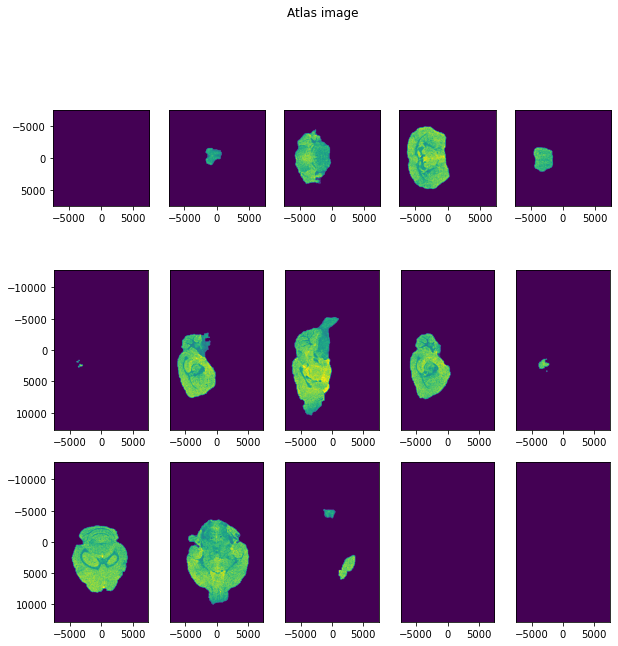

In [5]:
# atlas
imp.reload(emlddmm)
plt.rcParams["figure.figsize"] = (10,10)
xI,I,title,names = emlddmm.read_data(atlas_name)
I = I.astype(float)
# normalize
I /= np.mean(np.abs(I))
dI = np.array([x[1]-x[0] for x in xI])
print(dI)
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Atlas image')


Text(0.5, 1.0, 'Atlas pixel intensities')

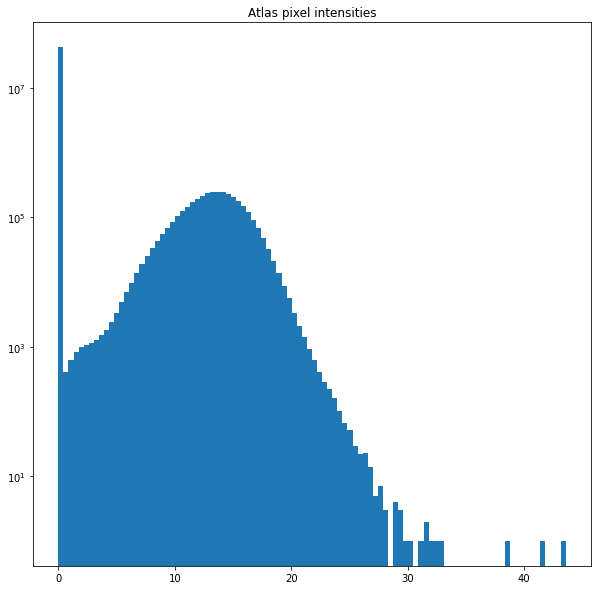

In [6]:
fig,ax = plt.subplots()
ax.hist(I.ravel(),bins=100,log=True)
ax.set_title('Atlas pixel intensities')

In [7]:
# initial downsampling so there isn't so much on the gpu
mindownI = np.min(np.array(downIs),0)
xI,I = emlddmm.downsample_image_domain(xI,I,mindownI)
downIs = [ list((np.array(d)/mindownI).astype(int)) for d in downIs]
dI = [x[1]-x[0] for x in xI]
print(dI)
nI = np.array(I.shape,dtype=int)
# update our config variable
config['downI'] = downIs

[100.0, 100.0, 100.0]


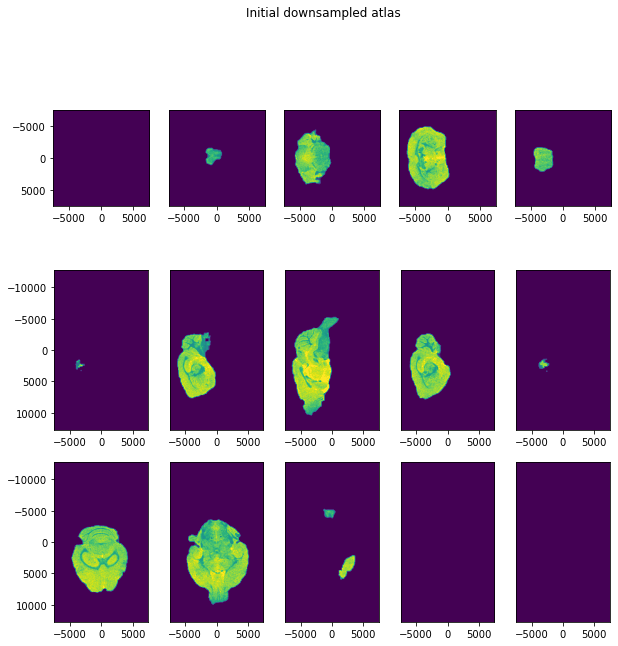

In [8]:
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Initial downsampled atlas')
fig[0].canvas.draw()

Found extension .vtk
[50. 50. 50.]


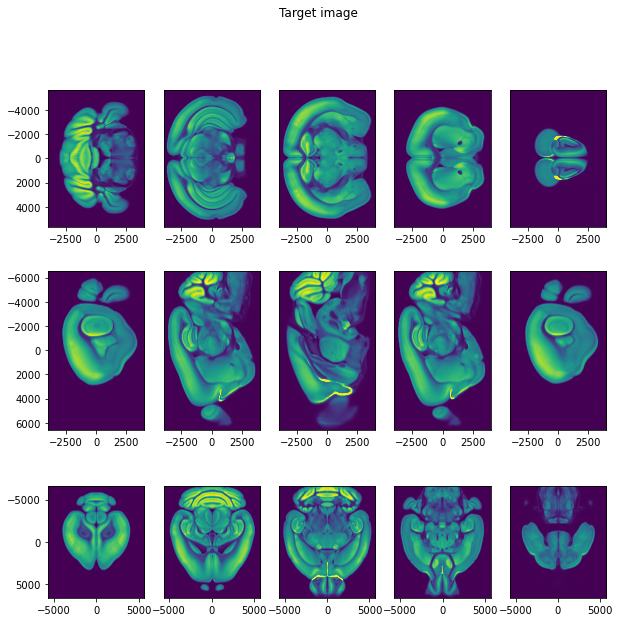

In [9]:
# target
imp.reload(emlddmm)
xJ,J,title,names = emlddmm.read_data(target_name)
J = J.astype(float)
J /= np.mean(np.abs(J))
xJ = [x for x in xJ]
dJ = np.array([x[1]-x[0] for x in xJ])
print(dJ)
J = J.astype(float)#**0.25
fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Target image')
fig[0].canvas.draw()
W0 = np.ones_like(J[0])


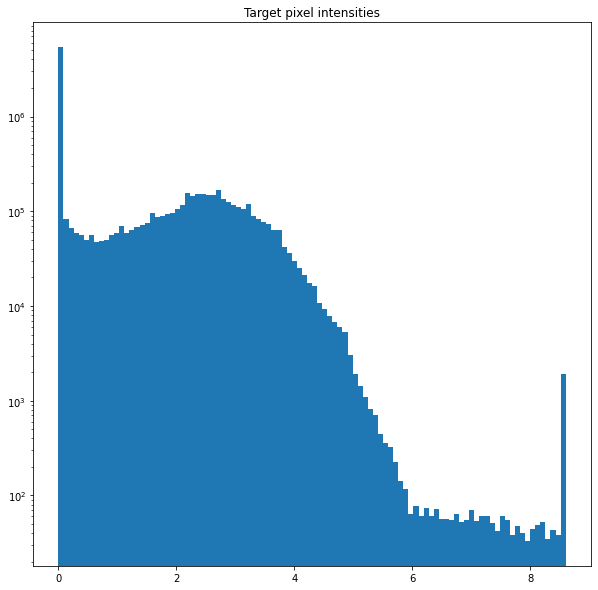

In [10]:
fig,ax = plt.subplots()
ax.hist(J.ravel(),bins=100,log=True)
ax.set_title('Target pixel intensities')
fig.canvas.draw()

In [11]:
# initial downsampling so there isn't so much on the gpu
mindownJ = np.min(np.array(downJs),0)
xJ,J = emlddmm.downsample_image_domain(xJ,J,mindownJ)
W0 = emlddmm.downsample(W0,mindownJ)
downJs = [ list((np.array(d)/mindownJ).astype(int)) for d in downJs]
dJ = [x[1]-x[0] for x in xJ]
print(dJ)
nJ = np.array(J.shape,dtype=int)
# update our config variable
config['downJ'] = downJs

[100.0, 100.0, 100.0]


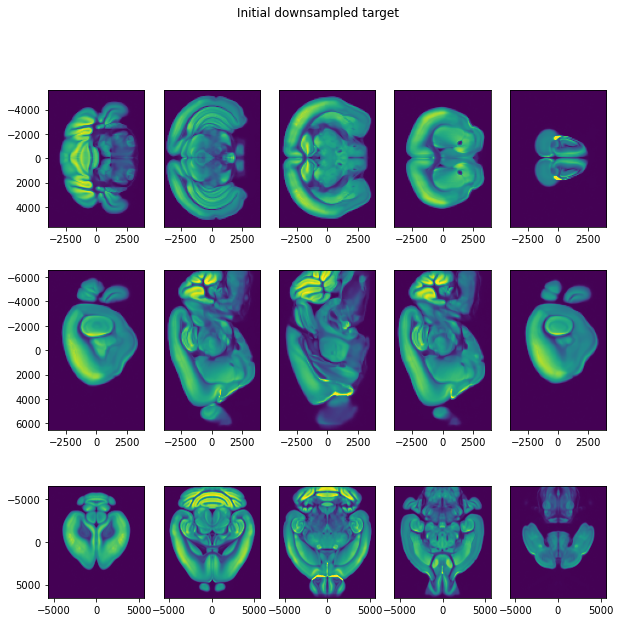

In [12]:
fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Initial downsampled target')
fig[0].canvas.draw()


[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


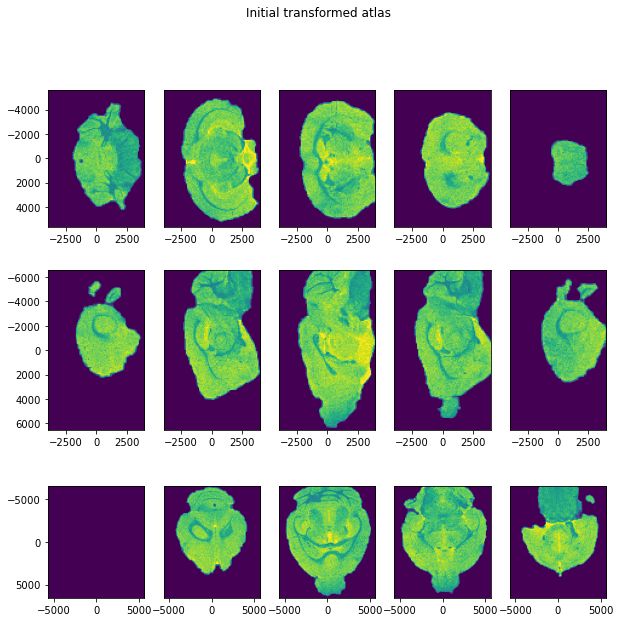

In [13]:
imp.reload(emlddmm)
# visualize initial affine
if 'A' in config:
    A = np.array(config['A']).astype(float)
else:
    A = np.eye(4)    
print(A)

# for simplicity I will add a translation manually 
A[:3,-1] = [-4000,100,4000]
config['A'] = A

# this affine matrix should be 4x4, but it may be 1x4x4
while A.ndim > 2:
    A = A[0]
Ai = np.linalg.inv(A)
XJ = np.stack(np.meshgrid(*xJ,indexing='ij'),-1)
Xs = (Ai[:3,:3]@XJ[...,None])[...,0] + Ai[:3,-1]
out = emlddmm.interp(xI,I,Xs.transpose((3,0,1,2)))
fig = emlddmm.draw(out,xJ)
fig[0].suptitle('Initial transformed atlas')
fig[0].canvas.draw()


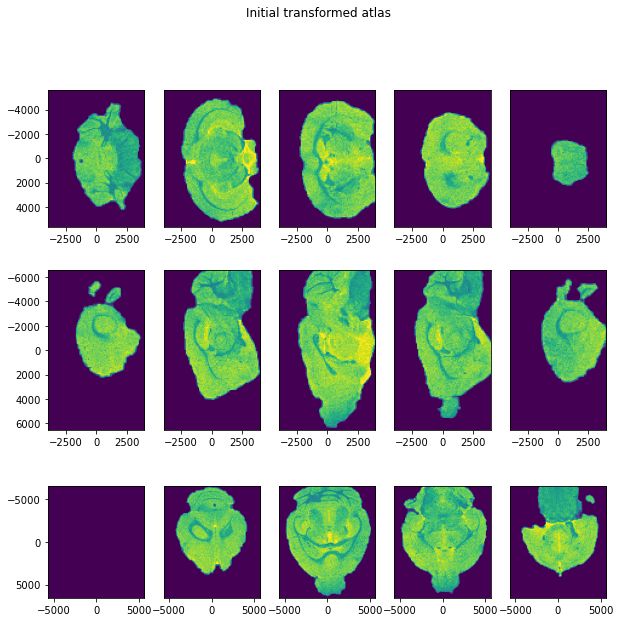

In [14]:
out = emlddmm.interp(xI,I,Xs.transpose((3,0,1,2)))
fig = emlddmm.draw(out,xJ)
fig[0].suptitle('Initial transformed atlas')
fig[0].canvas.draw()

Found 2 scales
dv tensor([300., 300., 300.], device='cuda:0')
a scale is 200.0


/home/brysongray/anaconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[W Copy.cpp:244] Warning: Casting complex values to real discards the imaginary part (function operator())
/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 0
Finished iteration 10
Finished iteration 20
Finished iteration 30
Finished iteration 40


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 50
Iteration 60, translation oscilating, reducing eA to 270000.0
Finished iteration 60
Finished iteration 70
Finished iteration 80
Iteration 90, translation oscilating, reducing eA to 243000.0
Finished iteration 90


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 100
Iteration 110, linear oscilating, reducing eA to 218700.0
Finished iteration 110
Iteration 120, translation oscilating, reducing eA to 196830.0
Finished iteration 120
Iteration 130, translation oscilating, reducing eA to 177147.0
Finished iteration 130
Iteration 140, translation oscilating, reducing eA to 159432.30000000002
Finished iteration 140
Iteration 150, linear oscilating, reducing eA to 143489.07


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 150
Finished iteration 160
Finished iteration 170
Finished iteration 180
Finished iteration 190


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 200
Finished iteration 210
Finished iteration 220
Finished iteration 230
Iteration 240, translation oscilating, reducing eA to 129140.16300000002
Finished iteration 240
Iteration 250, translation oscilating, reducing eA to 116226.14670000001


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 250
Iteration 260, linear oscilating, reducing eA to 104603.53203000002
Finished iteration 260
Iteration 270, translation oscilating, reducing eA to 94143.17882700001
Finished iteration 270
Finished iteration 280
Finished iteration 290
Iteration 300, translation oscilating, reducing eA to 84728.86094430002


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 300
Iteration 310, translation oscilating, reducing eA to 76255.97484987002
Finished iteration 310
Iteration 320, translation oscilating, reducing eA to 68630.37736488302
Finished iteration 320
Finished iteration 330
Finished iteration 340


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 350
Finished iteration 360
Iteration 370, translation oscilating, reducing eA to 61767.33962839472
Finished iteration 370
Finished iteration 380
Finished iteration 390


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 400
Iteration 410, translation oscilating, reducing eA to 55590.60566555525
Finished iteration 410
Iteration 420, translation oscilating, reducing eA to 50031.545098999726
Finished iteration 420
Finished iteration 430
Finished iteration 440
Iteration 450, translation oscilating, reducing eA to 45028.390589099756


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 450
Iteration 460, linear oscilating, reducing eA to 40525.55153018978
Finished iteration 460
Finished iteration 470
Finished iteration 480
Finished iteration 490
Iteration 500, translation oscilating, reducing eA to 36472.996377170806


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 500
Iteration 510, linear oscilating, reducing eA to 32825.69673945373
Finished iteration 510
Iteration 520 reducing ev to 1.71
Iteration 520, translation oscilating, reducing eA to 29543.127065508357
Finished iteration 520
Iteration 530, linear oscilating, reducing eA to 26588.814358957523
Finished iteration 530
Iteration 540, linear oscilating, reducing eA to 23929.93292306177
Finished iteration 540
Iteration 550 reducing ev to 1.539
Iteration 550, translation oscilating, reducing eA to 21536.939630755594
Finished iteration 550
Iteration 560 reducing ev to 1.3851
Iteration 560, translation oscilating, reducing eA to 19383.245667680036
Finished iteration 560
Iteration 570 reducing ev to 1.24659
Iteration 570, translation oscilating, reducing eA to 17444.921100912034
Finished iteration 570
Iteration 580 reducing ev to 1.121931
Iteration 580, translation oscilating, reducing eA to 15700.42899082083
Finished iteration 580
Iteration 590 reducing ev to 1.0097379
Iteratio

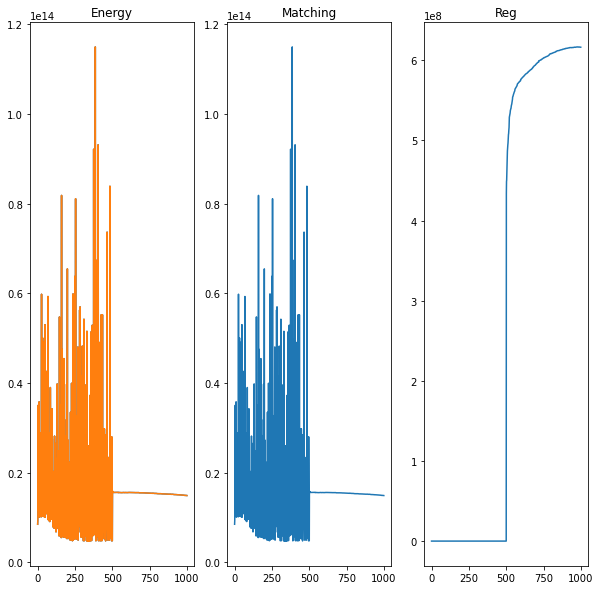

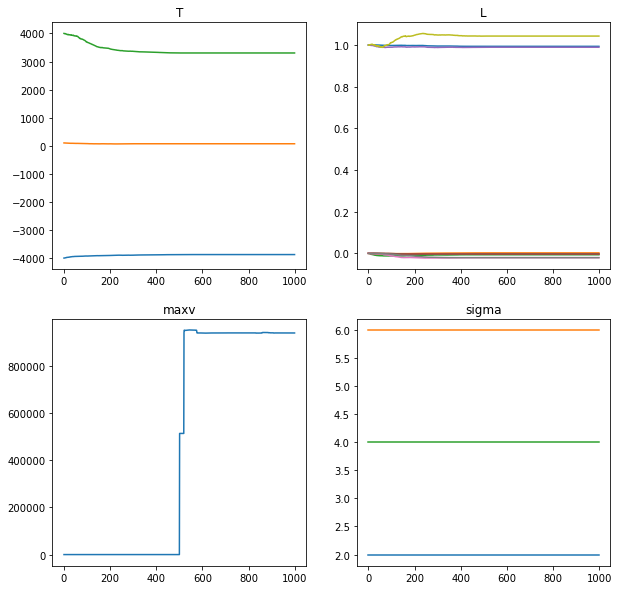

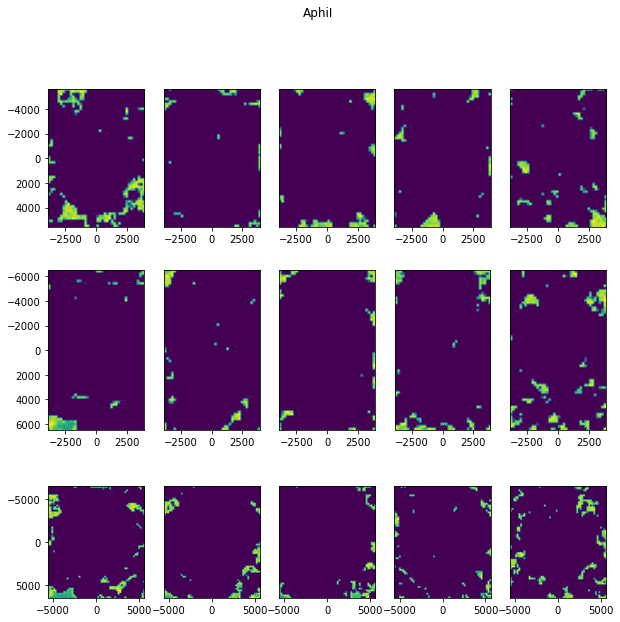

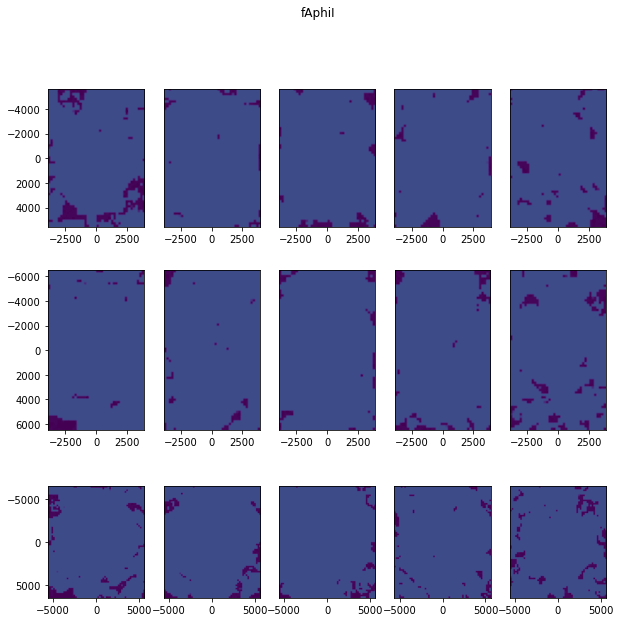

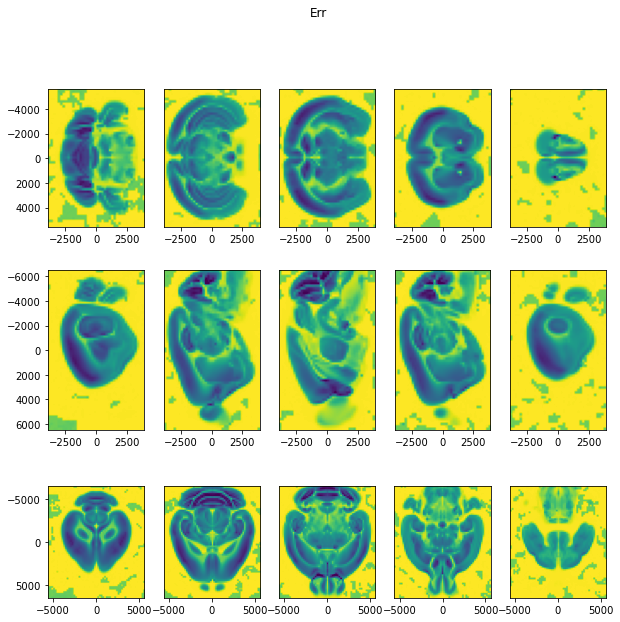

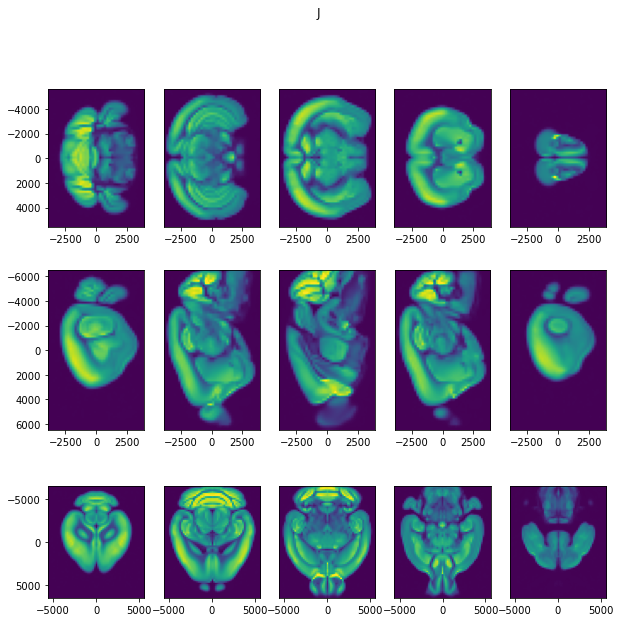

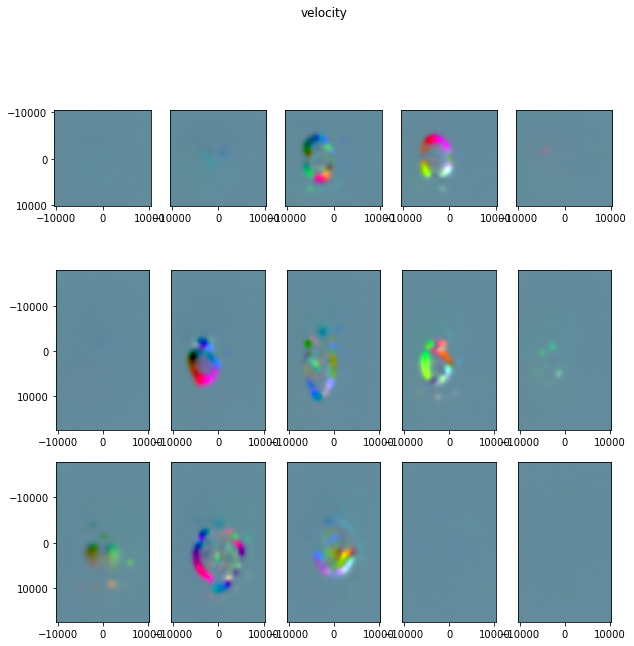

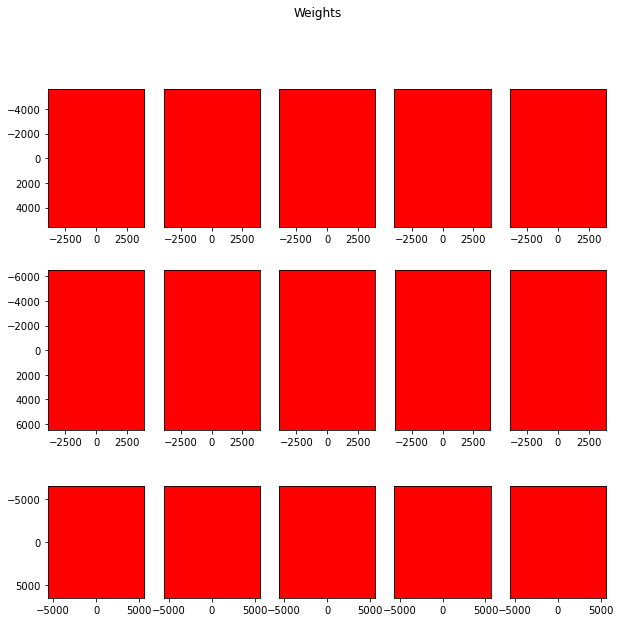

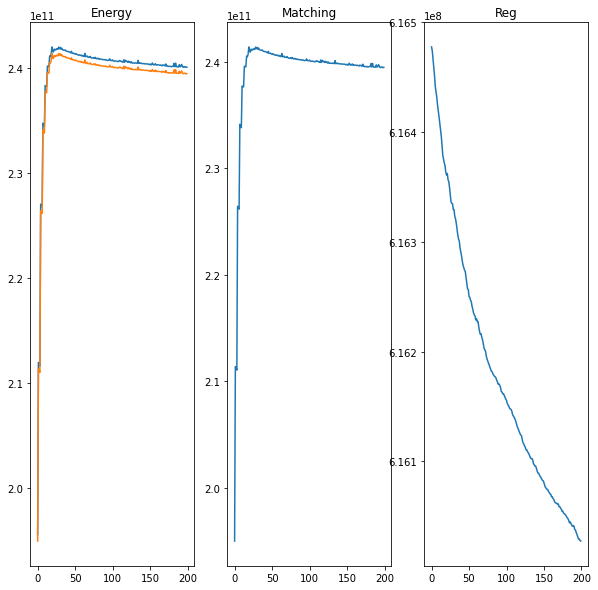

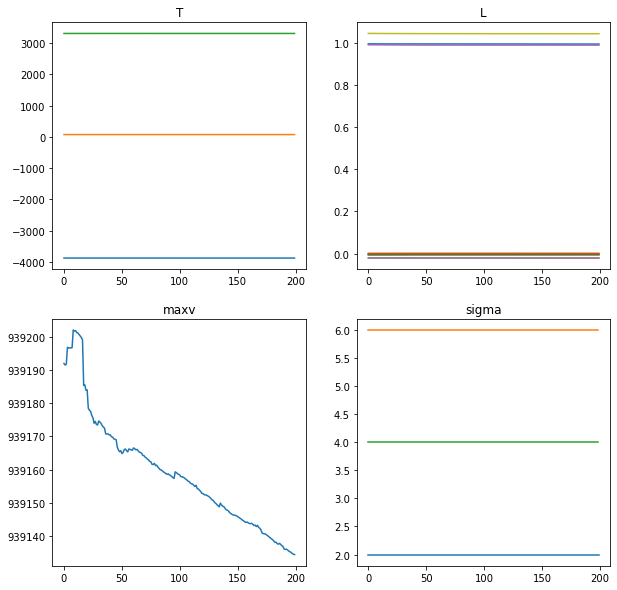

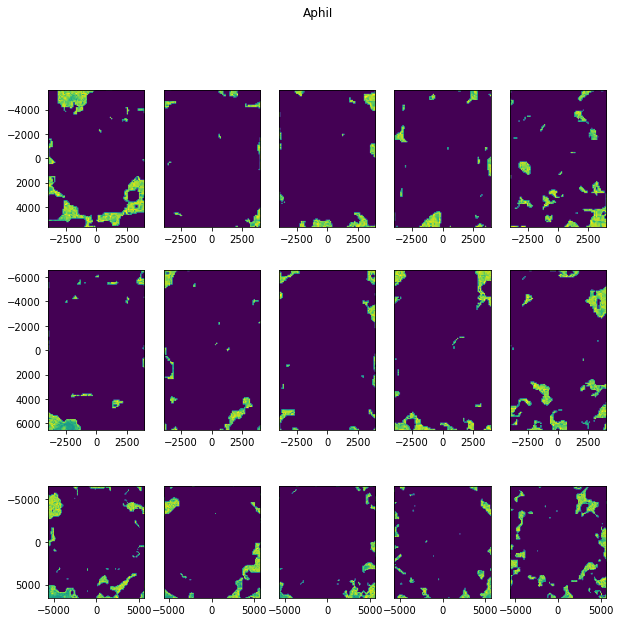

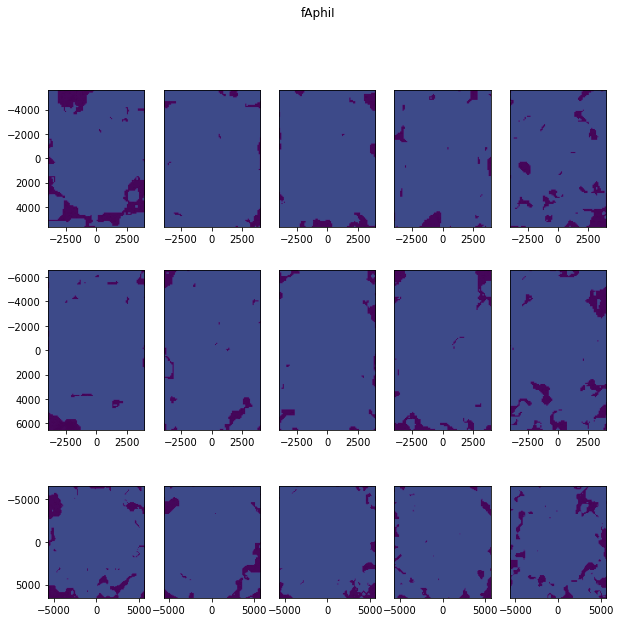

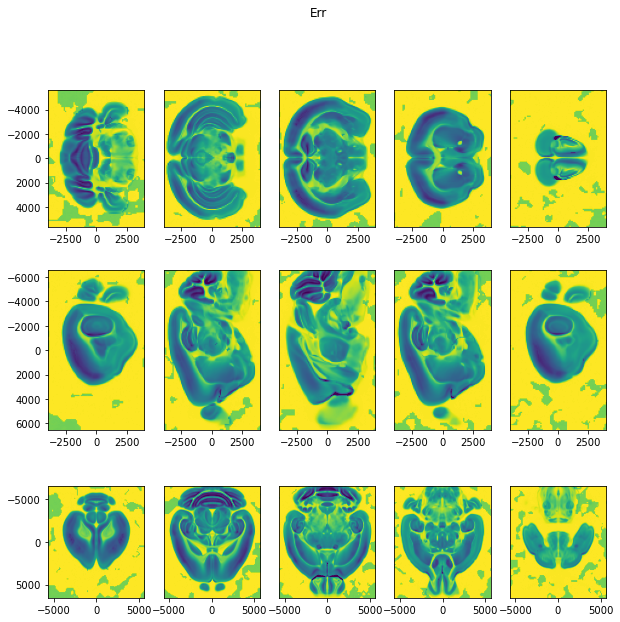

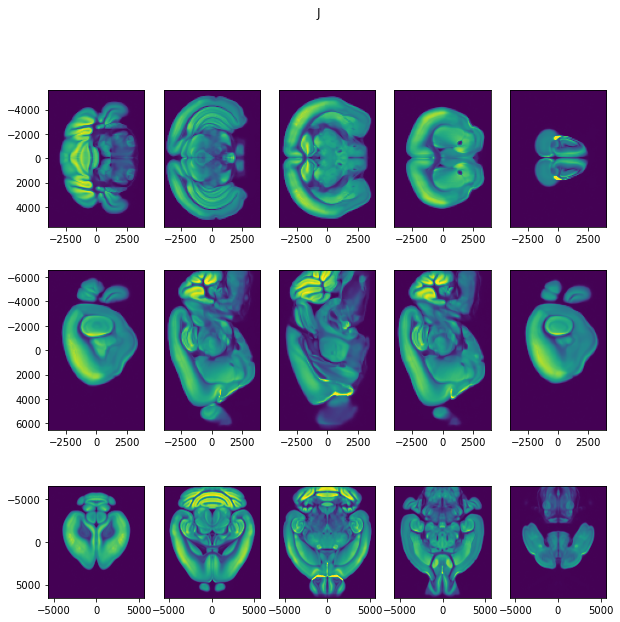

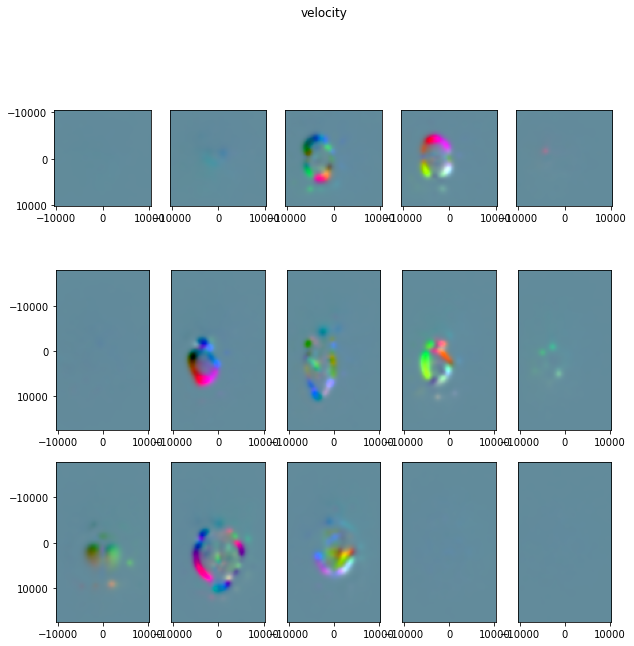

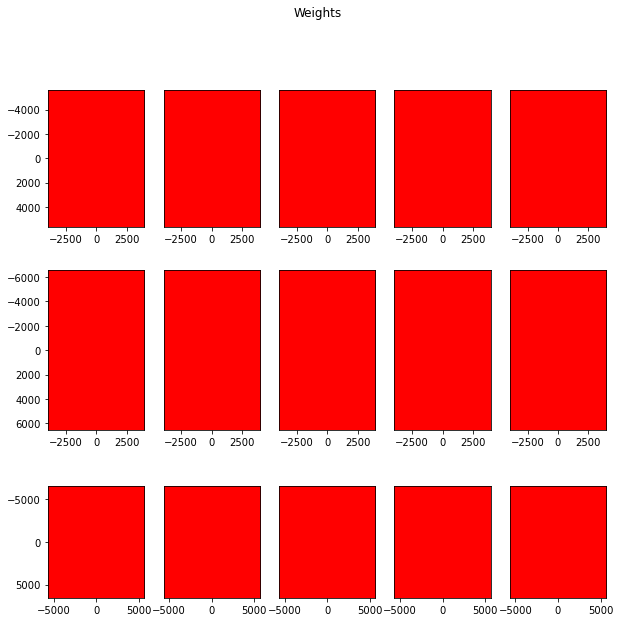

In [15]:
device = 'cuda:0'
#device = 'cpu'
output = emlddmm.emlddmm_multiscale(I=I,xI=[xI],J=J,xJ=[xJ],W0=W0,device=device,**config)

In [16]:
imp.reload(emlddmm)
emlddmm.write_transform_outputs(output_dir,output[-1])

In [1]:
imp.reload(emlddmm)
emlddmm.write_qc_outputs(output_dir,output[-1],xI,I,xJ,J,)

NameError: name 'imp' is not defined

In [ ]:
# apply forward transform (target image to atlas)
imp.reload(emlddmm)
Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xI]))
Xout = emlddmm.compose_sequence(output_dir,Xin)
Jt = emlddmm.apply_transform_float(xJ,J,Xout)

In [ ]:
fig = emlddmm.draw(Jt,xI)
fig[0].suptitle('Transformed target')
fig[0].canvas.draw()

In [ ]:
# apply backward transform (atlas images to target)
Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xJ]))
Xout = emlddmm.compose_sequence(output_dir,Xin,direction='b')
It = emlddmm.apply_transform_float(xI,I,Xout)

In [ ]:
fig = emlddmm.draw(It,xJ)
fig[0].canvas.draw()


In [ ]:
atlas_output_dir = os.path.join(output_dir,'to_atlas')
if not os.path.isdir(atlas_output_dir): os.mkdir(atlas_output_dir)
target_output_dir = os.path.join(output_dir,'to_target')
if not os.path.isdir(target_output_dir): os.mkdir(target_output_dir)

In [ ]:
# write transformed images, these are at low res
imp.reload(emlddmm)
ext = '.vtk'
if ext[0] != '.': ext = '.' + ext
imp.reload(emlddmm)
emlddmm.write_data(os.path.join(atlas_output_dir,'target_to_atlas'+ext),xI,Jt,'target_to_atlas')

emlddmm.write_data(os.path.join(target_output_dir,'atlas_to_target'+ext),xI,It,'atlas_to_target')

In [ ]:
# reload atlas at full res 
# atlas
imp.reload(emlddmm)
xI,I,title,names = emlddmm.read_data(atlas_name)
I = I.astype(float)
# normalize
I /= np.mean(np.abs(I))
dI = np.array([x[1]-x[0] for x in xI])
print(dI)
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Atlas image')



# transform target images at full res
xJ,J,title,names = emlddmm.read_data(target_name)
J = J.astype(float)
J /= np.mean(np.abs(J))
xJ = [x for x in xJ]
dJ = np.array([x[1]-x[0] for x in xJ])
print(dJ)
J = J.astype(float)#**0.25
fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Target image')
fig[0].canvas.draw()

Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xI]))
Xout = emlddmm.compose_sequence(output_dir,Xin)
Jt = emlddmm.apply_transform_float(xJ,J,Xout)

fig = emlddmm.draw(Jt,xI)
fig[0].suptitle('Target to atlas')
fig[0].canvas.draw()

# write out
outname = os.path.splitext(os.path.split(target_name)[1])[0]
outname = os.path.join(atlas_output_dir,outname+ext)
emlddmm.write_data(outname,xI,Jt,'target_to_atlas')